In [292]:
import matplotlib.lines as mlines
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
sns.set_palette("colorblind")

warnings.filterwarnings('ignore')



In [293]:
column_our_method = ['dataset', 'method',  'runtime',
                     'mrr',  'All_RecallAtSizeofGroundTruth', 'All_F1Score']
column_other_methods = ['usecase', 'matcher', 'runtime',
                        'MRR',  'RecallAtSizeofGroundTruth', 'F1Score']


def load_other_methods(path, case=None):
    df = pd.read_csv(path)

    df['runtime'] = df['runtime'].apply(lambda x: x/1000)

    if case == 'Union':
        df = df[df['taskname'].str.contains('union', case=False)]

    df = df[column_other_methods]
    df.columns = column_our_method

    return df


def load_our_methods(path, case=None):
    files = glob.glob(path)

    all_dfs_dict = {}
    for file in files:
        df = pd.read_csv(file)
        datasetname = df['dataset'].unique()[0]
        all_dfs_dict[datasetname] = df

    df = pd.concat(all_dfs_dict)
    df = df.reset_index(drop=True)

    if case == 'Union':
        df_fab = df[~df['dataset'].isin(['Magellan', 'musicians'])]
        df_fab = df_fab[df_fab['type'].str.contains(
            'Unionable|View-Unionable', case=False)]

        df_mus = df[df['dataset'] == 'musicians']
        df_mus = df[df['source_table'].str.contains('union', case=False)]

        df_mag = df[df['dataset'] == 'Magellan']

        df = pd.concat([df_fab, df_mus, df_mag])

    df = df[column_our_method]

    return df

In [294]:
def fix_df(df):

    mapping = {
        'datasets/WikidataHumanCurated': 'Wikidata',
        'musicians': 'Wikidata',
        'datasets/MagellanHumanCurated': 'Magellan',
        'datasets/TPC-DI': 'TPC-DI',
        'datasets/OpenData': 'OpenData',
        'datasets/ChEMBL': 'ChEMBL'
    }
    df['dataset'] = df['dataset'].apply(lambda x: mapping.get(x, x))

    df = df.rename(columns={'All_RecallAtSizeofGroundTruth': 'Recall@GT'})
    df = df.rename(columns={'All_F1Score': 'F1'})
    df = df.rename(columns={'mrr': 'MRR'})

    df = df.round(3)

    return df

In [295]:
metrics = ['MRR', 'Recall@GT']


def plot(df, ax, metric, hue_order, legend=False):

    x = sorted(df['dataset'].unique())

    sns.boxplot(
        palette=sns.color_palette("Set2"),  # Use a better palette
        x='dataset',
        y=metric,
        hue='method',
        hue_order=hue_order,
        data=df,
        ax=ax,
        showfliers=False,
        width=0.5
    )
    # ax.set_title(f'{metric} by Dataset and Method')
    ax.set_xlabel(None)
    ax.set_ylabel(metric)
    ax.tick_params(axis='both', which='major', labelsize=14)

    ax.set_ylabel(metric, fontsize=14)

    ax.set_ylim(-0.01, 1.01)

    if legend:
        ax.legend(
            title=None,
            loc='lower center',
            bbox_to_anchor=(0.5, 1.01),
            ncol=len(df['method'].unique()),
            frameon=False,
            fontsize=14
        )
    else:
        ax.get_legend().remove()

    


def plot_bars_all(df, figsize=(9, 5),  save=None):

    df = df.sort_values(by='dataset')

    hue_order = df.groupby('method')['MRR'].mean(
    ).sort_values().index.tolist()  # change for recall

    fig, axis = plt.subplots(len(metrics), 1, figsize=figsize, sharex=True)

    for i, metric in enumerate(metrics):
        plot(df, axis[i], metric, hue_order=hue_order, legend=(i == 0))

    sns.despine()

    if save is not None:
        plt.savefig(save, dpi=300)

In [296]:
def analyze(df, metric):
    grouped = df.groupby('method')[metric].agg(['mean', 'median', 'min', 'max', 'std'])
    grouped = grouped.sort_values(by='mean', ascending=False)
    grouped = grouped.round(3)
    print('General stats')
    print(grouped)

    print('\n')

    grouped = df.groupby(['dataset', 'method'])[metric].agg(['mean', 'median', 'min', 'max', 'std'])
    
    grouped = grouped.groupby(level=0).apply(lambda x: x.sort_values(by='mean', ascending=False))

    grouped = grouped.round(3)
    print('Per dataset stats')
    print(grouped)


In [297]:
main_path = 'server_results/main_experiment/'
unicorn_path = main_path + 'Unicorn__top20__results.csv'
isresmat_path = main_path + 'ISResMat__top20__results.csv'
mm_path = main_path + 'matchmaker_bp/*.csv'
mmstr_path = main_path + 'matchmaker_bpstr/*.csv'
mm_gpt_path = main_path + 'matchmaker_gpt/*.csv'



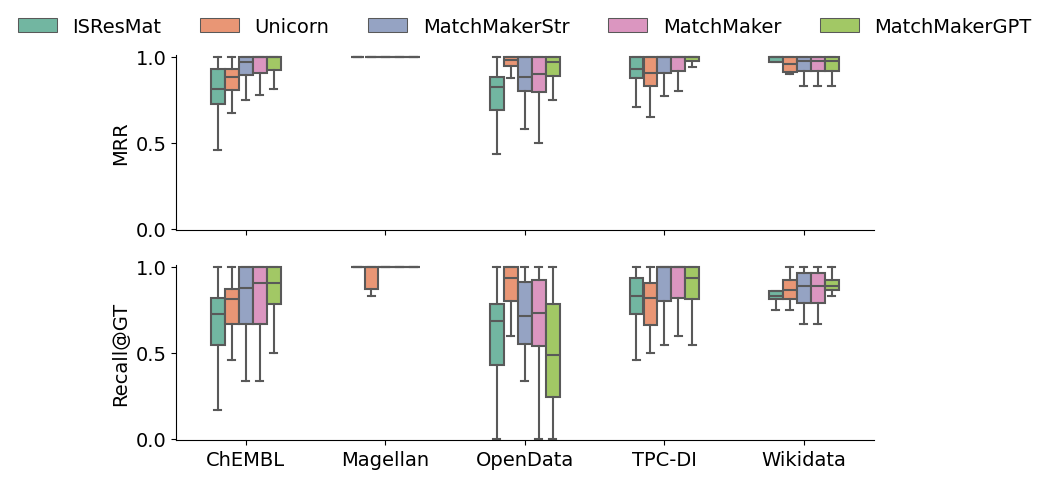

In [ ]:
unicorn_df = load_other_methods(unicorn_path)
isresmat_df = load_other_methods(isresmat_path)
mm_df = load_our_methods(mm_path)
mmstr_df = load_our_methods(mmstr_path)
mm_gpt_df = load_our_methods(mm_gpt_path)

df = pd.concat([unicorn_df, isresmat_df, mm_df,  mm_gpt_df])

df = fix_df(df)
plot_bars_all(df, save='figures/main_experiment_all_methods.pdf')

In [299]:
analyze(df, 'MRR')

General stats
                mean  median    min  max    std
method                                         
MatchMakerGPT  0.957   1.000  0.500  1.0  0.075
MatchMaker     0.919   0.986  0.481  1.0  0.112
MatchMakerStr  0.918   0.955  0.100  1.0  0.109
Unicorn        0.887   0.934  0.083  1.0  0.166
ISResMat       0.842   0.864  0.125  1.0  0.148


Per dataset stats
                                  mean  median    min  max    std
dataset  dataset  method                                         
ChEMBL   ChEMBL   MatchMakerGPT  0.949   1.000  0.500  1.0  0.091
                  MatchMaker     0.931   1.000  0.500  1.0  0.111
                  MatchMakerStr  0.924   0.969  0.100  1.0  0.128
                  Unicorn        0.814   0.886  0.200  1.0  0.211
                  ISResMat       0.812   0.812  0.270  1.0  0.145
Magellan Magellan MatchMaker     1.000   1.000  1.000  1.0  0.000
                  MatchMakerGPT  1.000   1.000  1.000  1.0  0.000
                  MatchMakerStr  1.0

In [300]:
analyze(df, 'Recall@GT')

General stats
                mean  median  min  max    std
method                                       
Unicorn        0.791   0.833  0.0  1.0  0.234
MatchMaker     0.788   0.875  0.0  1.0  0.263
MatchMakerStr  0.780   0.833  0.0  1.0  0.258
MatchMakerGPT  0.743   0.833  0.0  1.0  0.299
ISResMat       0.687   0.750  0.0  1.0  0.268


Per dataset stats
                                  mean  median    min   max    std
dataset  dataset  method                                          
ChEMBL   ChEMBL   MatchMakerGPT  0.838   0.909  0.000  1.00  0.229
                  MatchMaker     0.802   0.909  0.000  1.00  0.248
                  MatchMakerStr  0.793   0.875  0.000  1.00  0.243
                  Unicorn        0.706   0.812  0.000  1.00  0.294
                  ISResMat       0.639   0.727  0.000  1.00  0.284
Magellan Magellan MatchMaker     1.000   1.000  1.000  1.00  0.000
                  MatchMakerGPT  1.000   1.000  1.000  1.00  0.000
                  MatchMakerStr  1.000   